# Analysis of Density Functional Theory on a 1d Ising Model with 1nn interaction

The Hamiltonian is given by

$H=J \sum_i x_i x_{i+1} + \sum_i h_i z_i $  $\; \;$ with $h_i \in [0,h_{max}]$ and $J<0$

## Case a) Scalability of the Functional at different $h_{max}$

#### Imports

In [4]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy import fft, ifft
from tqdm.notebook import tqdm, trange
from src.training.utils_analysis import dataloader, nuv_representability_check,mean_field_functional_1nn

#### Data

In [8]:
n_sample=7
t_range=[49,49,49,199,199,799,799]
h_max=[4.5]*n_sample
ls=[16,32,64,128,256,512,1024]
n_instances=[100]*n_sample
epochs = [[i * 100 for i in range(t_range[j])] for j in range(n_sample)] 
# model settings
name_session=[f'h_{h_max[i]}_150k_augmentation_1nn_model_unet_{ls[i]}_size_2_layers_20_hc_5_ks_2_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
hs={}

for i in range(n_sample):
    min_eng=[]
    gs_eng=[]
    min_n=[]
    gs_n=[]
    hs[ls[i]]=np.load(f'data/dataset_1nn/valid_unet_periodic_{ls[i]}_l_{h_max[i]}_h_15000_n.npz')['potential'][0:n_instances[i]]
    for j in range(t_range[i]):    
        min_eng_t,gs_eng_t=dataloader('energy',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i][j],early_stopping=False,variable_lr=False,n_ensambles=1)
        min_n_t,gs_n_t=dataloader('density',session_name=name_session[i],n_instances=n_instances[i],lr=loglr,diff_soglia=1,epochs=epochs[i][j],early_stopping=False,variable_lr=False,n_ensambles=1)
        
        min_eng_t=np.asarray(min_eng_t)
        gs_eng_t=np.asarray(gs_eng_t)
        min_n_t=np.asarray(min_n_t)
        gs_n_t=np.asarray(gs_n_t)
        
        if j==0:
            min_eng=min_eng_t.reshape(1,-1)
            gs_eng=gs_eng_t.reshape(1,-1)
            min_n=min_n_t.reshape(1,-1,ls[i])
            gs_n=gs_n_t.reshape(1,-1,ls[i])
        else:
            #if min_eng_t.shape[0]==min_eng.shape[-1]:
            min_eng=np.append(min_eng,min_eng_t.reshape(1,-1),axis=0)
            gs_eng=np.append(gs_eng,gs_eng_t.reshape(1,-1),axis=0)
            min_n=np.append(min_n,min_n_t.reshape(1,-1,ls[i]),axis=0)
            gs_n=np.append(gs_n,gs_n_t.reshape(1,-1,ls[i]),axis=0)
            
        
    # min_eng=np.asarray(min_eng,dtype=object)
    # gs_eng=np.asarray(gs_eng,dtype=object)
    # min_n=np.asarray(min_n,dtype=object)
    # gs_n=np.asarray(gs_n,dtype=object)

    min_energy[ls[i]]=min_eng
    gs_energy[ls[i]]=gs_eng
    min_density[ls[i]]=min_n
    gs_density[ls[i]]=gs_n
    print(gs_n.shape)

(49, 100, 16)
(49, 100, 32)
(49, 100, 64)
(199, 100, 128)
(199, 100, 256)
(799, 100, 512)
(799, 100, 1024)


#### Convergence of $|\Delta e|/|e|$ for different sizes

mf error= 0.08391271170454222
16
(49, 100)
(49, 100)
mf error= 0.08923679721071172
32
(49, 100)
(49, 100)
mf error= 0.0889069923576682
64
(49, 100)
(49, 100)
mf error= 0.08569391582287977
128
(199, 100)
(199, 100)
mf error= 0.08731542790396427
256
(199, 100)
(199, 100)
mf error= 0.08614486123532727
512
(799, 100)
(799, 100)
mf error= 0.08674273510411795
1024
(799, 100)
(799, 100)


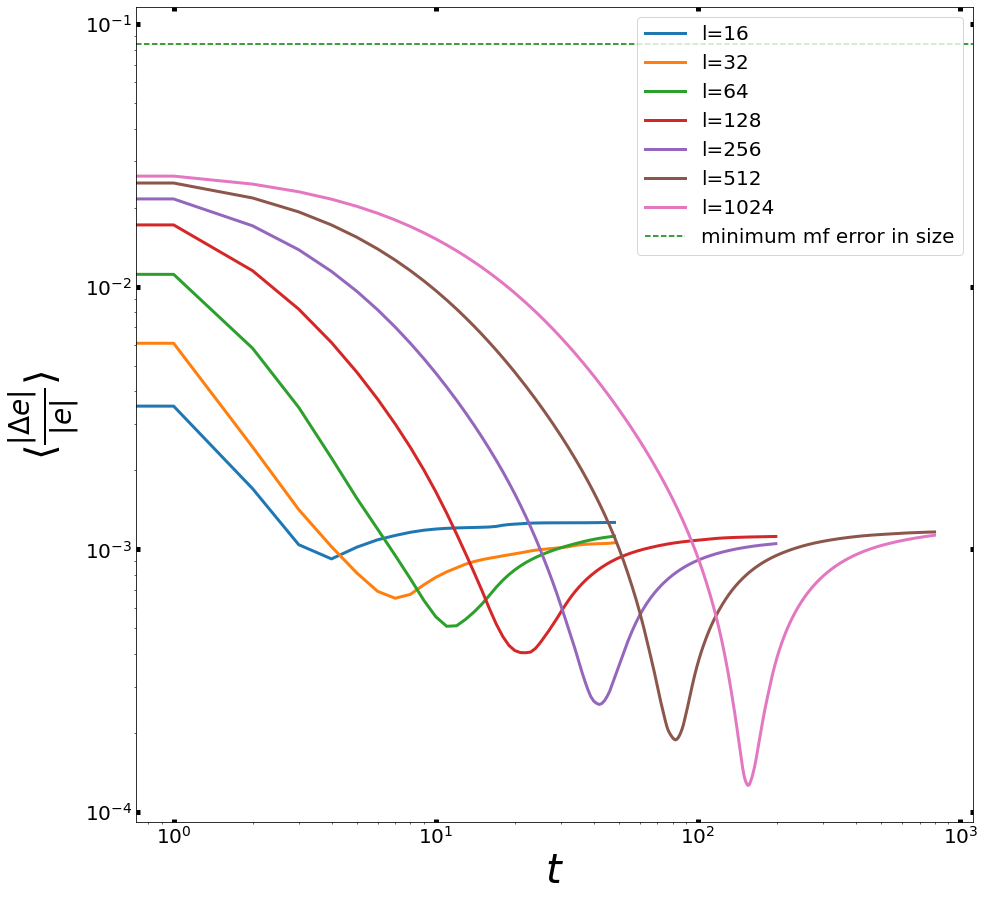

In [13]:


fig=plt.figure(figsize=(15,15))
errors_e=[]
sigma_errors_e=[]
de_mf_min=1000
for l in ls:
    #mean field computation
    e_mf=mean_field_functional_1nn(gs_density[l][-1],hs[l])
    de_mf=np.average(np.abs(e_mf/l-gs_energy[l]))
    #plot the minimum mf error
    if de_mf< de_mf_min:
        de_mf_min=de_mf
    print('mf error=',de_mf)
    
    print(l)
    print(min_energy[l].shape)
    print(gs_energy[l].shape)
    e_av=np.average(np.abs(min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]),axis=-1)
    plt.plot(e_av,label=f'l={l}',linewidth=3)
    errors_e.append(e_av[-1])
    sigma_errors_e.append(np.std(np.abs(min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]),axis=-1)[-1])
plt.legend(fontsize=20)
plt.xlabel(r'$t$',fontsize=40)
plt.ylabel(r'$\langle\frac{\left| \Delta e \right|}{\left| e \right|}\rangle$',fontsize=40)
plt.axhline(y=de_mf_min,label=f'minimum mf error in size',linestyle='--',color='green')
    

plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=5,
        )
plt.xticks([1000,5000,10000,15000,20000,25000,30000,60000,80000],[r'$10^3$',r'$5 \cdot 10^3$',r'$10^4$',r'$1.5 \cdot 10^4$',r'$2 \cdot 10^4$',r'$2.5 \cdot 10^4$',r'$3 \cdot 10^4$',r'$6 \cdot 10^4 $',r"$8 \cdot 10^4$"])
plt.yticks([0.05,0.01,0.005,0.001],[r'$5 \cdot 10^{-2}$',r'$10^{-2}$',r'$5 \cdot 10^{-3}$',r'$ 10^{-3}$'])
#plt.axhline(10**-5,color='red',linestyle='--',linewidth=2,label=r'$0.001 \%$ error')
plt.loglog()
plt.legend(fontsize=20)
plt.show()

#### Convergence of $\Delta e/ e$ for different sizes

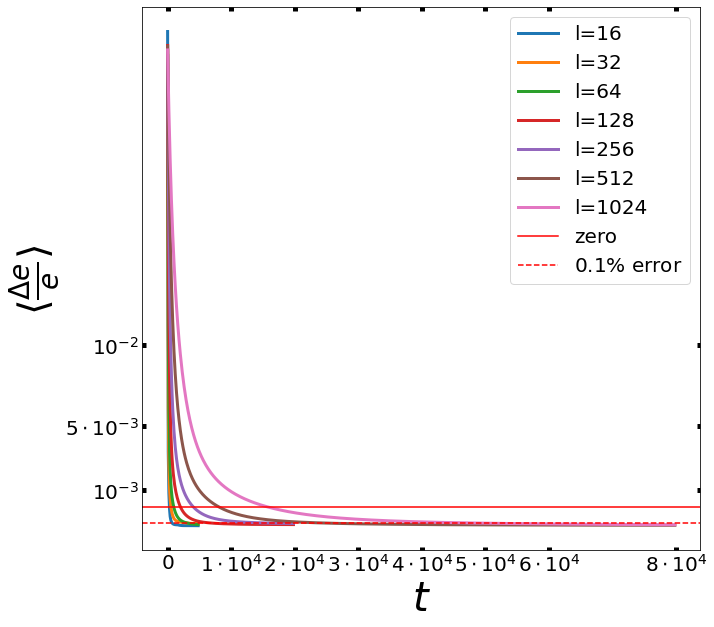

In [4]:
fig=plt.figure(figsize=(10,10))
for i,l in enumerate(ls):
    e_av=np.average((min_energy[l]-gs_energy[l])/np.abs(gs_energy[l]),axis=1)
    plt.plot(epochs[i],e_av,label=f'l={l}',linewidth=3)
plt.legend(fontsize=20)
plt.xlabel(r'$t$',fontsize=40)
plt.ylabel(r'$\langle\frac{\Delta e}{ e }\rangle$',fontsize=40)

plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=5,
        )
plt.xticks([0,10000,20000,30000,40000,50000,60000,80000],[r'$0$',r'$1 \cdot 10^4$',r'$2 \cdot 10^4$',r'$3 \cdot 10^4$',r'$4 \cdot 10^4$',r'$5 \cdot 10^4$',r'$6 \cdot 10^4$',r'$8 \cdot 10^4$'])
plt.yticks([0.01,0.005,0.001],[r'$10^{-2}$',r'$5 \cdot 10^{-3}$',r'$ 10^{-3}$'])
plt.axhline(-0.00,color='red',label='zero')
plt.axhline(-0.001,color='red',linestyle='--',label=r'$0.1 \%$ error')
#plt.semilogy()
plt.legend(fontsize=20)
plt.show()

#### Convergence of $ |\Delta z|/ |z| $ for different sizes

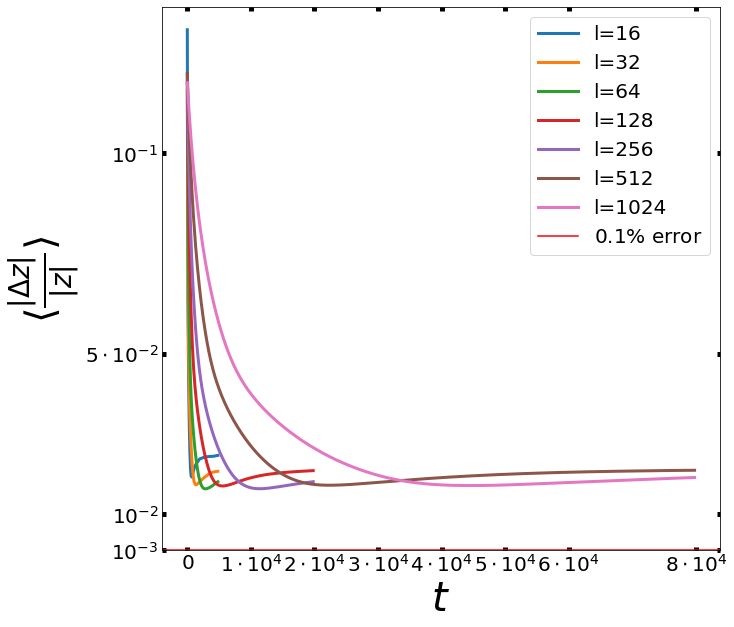

In [5]:
fig=plt.figure(figsize=(10,10))
errors_n=[]
sigma_errors_n=[]
for i,l in enumerate(ls):
    dn_av=np.average((np.average(np.abs(min_density[l]-gs_density[l]),axis=-1)/np.average(np.abs(gs_density[l]),axis=-1)),axis=1)
    plt.plot(epochs[i],dn_av,label=f'l={l}',linewidth=3)
    errors_n.append(dn_av[-1])
    sigma_errors_n.append(np.std((np.average(np.abs(min_density[l]-gs_density[l]),axis=-1)/np.average(np.abs(gs_density[l]),axis=-1)),axis=1)[-1])
plt.legend(fontsize=20)
plt.xlabel(r'$t$',fontsize=40)
plt.ylabel(r'$\langle\frac{\left|\Delta z \right|}{\left| z \right|}\rangle$',fontsize=40)

plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=20,
            width=5,
        )
plt.xticks([0,10000,20000,30000,40000,50000,60000,80000],[r'$0$',r'$1 \cdot 10^4$',r'$2 \cdot 10^4$',r'$3 \cdot 10^4$',r'$4 \cdot 10^4$',r'$5 \cdot 10^4$',r'$6 \cdot 10^4$',r"$8 \cdot 10^4$"])
plt.yticks([0.1,0.05,0.01,0.001],[r"$10^{-1}$",r'$5 \cdot 10^{-2}$',r'$10^{-2}$',r'$ 10^{-3}$'])
plt.axhline(0.001,color='red',label=r'$0.1 \%$ error')
#plt.semilogy()
plt.legend(fontsize=20)
plt.show()

#### Steady values vs size

##### Magnetization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


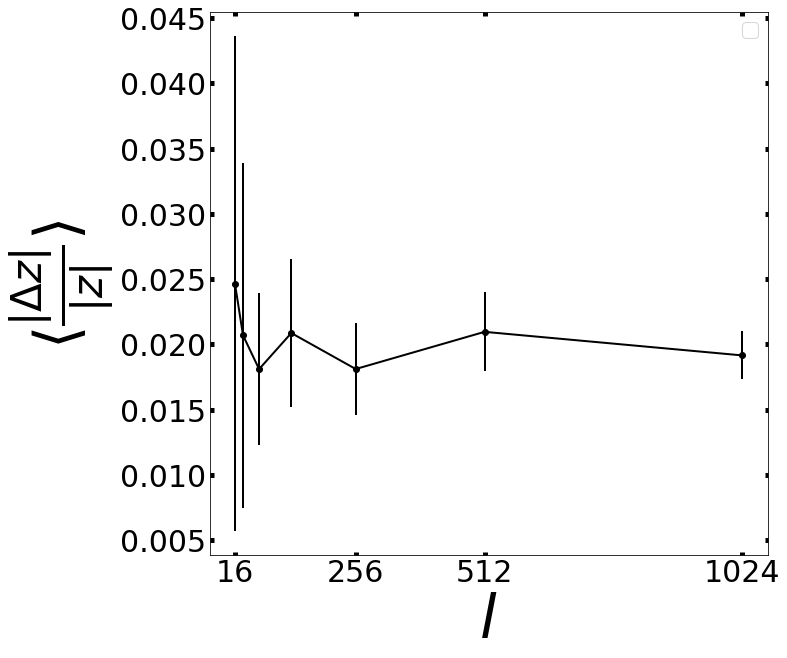

In [6]:
plt.figure(figsize=(10,10))
plt.errorbar(ls,errors_n,yerr=sigma_errors_n,color='black',marker='o',linewidth=2)
plt.legend(fontsize=20)
plt.xlabel(r'$ l $',fontsize=60)
plt.ylabel(r'$ \langle \frac{\left| \Delta z \right|}{\left|z \right|} \rangle $',fontsize=60)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.xticks([16,256,512,1024],[16,256,512,1024])
plt.show()

##### Energy

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


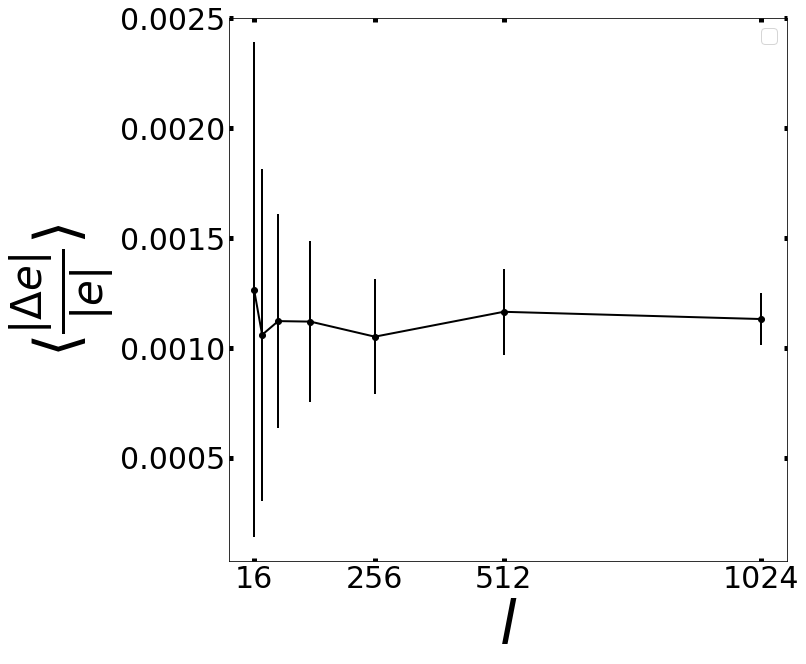

In [7]:
t=-1
plt.figure(figsize=(10,10))
plt.errorbar(ls,errors_e,yerr=sigma_errors_e,color='black',marker='o',linewidth=2)
plt.legend(fontsize=20)
plt.xlabel(r'$ l $',fontsize=60)
plt.ylabel(r'$ \langle \frac{\left| \Delta e \right|}{\left|e \right|} \rangle $',fontsize=60)
plt.tick_params(
            top=True,
            right=True,
            labeltop=False,
            labelright=False,
            direction="in",
            labelsize=30,
            width=5,
        )
plt.xticks([16,256,512,1024],[16,256,512,1024])
plt.show()

#### Non unique V-representability issue dfs

As in the article "Penz M, van Leeuwen R. Density-functional theory on graphs. J Chem Phys. 2021 Dec 28;155(24):244111. doi: 10.1063/5.0074249. PMID: 34972357", we can check if the H-K mapping holds for different configuration of the disorder.

Even if we can check that the mapping is always invertible, in some cases can rise numerical instabilities due to a quasi-non unique v-representability (different fields lead to very similar z).

A possible way to find this problem is the following. The mapping $\vec{z} \rightarrow \vec{h}$ is described by $\frac{\delta F}{\delta \vec{z}}= - \vec{h}$ in a ground state configuration (target point). This means that we can treat the GRADIENT of the machine learning functional in the target point as an effective field $\frac{\delta F}{\delta \vec{z}}= - \vec{h_{eff}}$. If the minimum point is exact, we should have $\vec{h_{eff}}=\vec{h}$. However, the min has some numerical errors that leads to $|\vec{h_{eff}}-\vec{h}|\ne 0$. Sometimes this error is caused by multiple representation of $\vec{h}$ for a given configuration. 

To check if we are in this situation, we can study if the magnetization $\vec{z}$ in the ground state of the following hamiltonian

$H=J\sum_i x_i x_{i+1} +\sum_i \frac{\delta F}{\delta z_i}[z_{min,i}] z_i$

is equal to the magnetization that generates the gradient. If we have $ |\vec{z}-\vec{z_{eff}}|\ll |\vec{h}-\vec{h_eff}|$ then we show that the mapping in that configuration is compromised by a multivalue condition

(100, 128)
v_shape= (15000, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(100, 128)
(100, 128)
v_shape= (15000, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(100, 128)
(100, 128)
v_shape= (1000, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(100, 128)
(100, 128)
v_shape= (15000, 128)


  0%|          | 0/10 [00:00<?, ?it/s]

(100, 128)
(100,)
(100,)
(100,)
(100,)


Text(0, 0.5, '$\\frac{1}{N}\\sum_j \\frac{\\sum_i \\left| h^{(j)}_i - h^{(j)}_{pseudo,i}\\right|}{\\sum_i \\left| z^{(j)}_i - z^{(j)}_{1,i}\\right|}$')

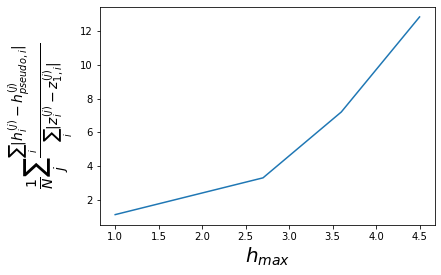

In [16]:
n_sample=4
h_max=[1.0,2.7,3.6,4.5]
ls=[128]*n_sample
n_instances=[100]*n_sample
epochs = [7900]*n_sample 
# model settings
name_session=[f'h_{h_max[i]}_150k_augmentation_1nn_model_unet_{ls[i]}_size_2_layers_20_hc_5_ks_2_ps' for i in range(n_sample)]
early_stopping=False
variational_lr=False
loglr=1

min_density={}
gs_density={}
min_energy={}
gs_energy={}
g_acc={}
z_acc={}

for r in range(n_sample):

    min_eng,gs_eng=dataloader('energy',session_name=name_session[r],n_instances=n_instances[r],lr=loglr,diff_soglia=1,epochs=epochs[r],early_stopping=False,variable_lr=False,n_ensambles=1)
    min_n,gs_n=dataloader('density',session_name=name_session[r],n_instances=n_instances[r],lr=loglr,diff_soglia=1,epochs=epochs[r],early_stopping=False,variable_lr=False,n_ensambles=1)
    
    min_eng=np.asarray(min_eng)
    gs_eng=np.asarray(gs_eng)
    min_n=np.asarray(min_n)
    gs_n=np.asarray(gs_n)
    print(gs_n.shape)
        
    model_name=f'1nn_ising/h_{h_max[r]}_150k_augmentation_unet_periodic_1nn_model_cnn_[20, 40]_hc_5_ks_2_ps_2_nconv_0_nblock'
    model=torch.load('model_rep/'+model_name,map_location='cpu')
    model.eval()
    v=np.load(f'data/dataset_1nn/valid_unet_periodic_{ls[r]}_l_{h_max[r]}_h_15000_n.npz')['potential']
    print('v_shape=',v.shape)
    dg,dz=nuv_representability_check(model,z=gs_n,v=v[:gs_n.shape[0]],plot=False,gs_z=gs_n)
    
    
    min_energy[h_max[r]]=min_eng
    gs_energy[h_max[r]]=gs_eng
    min_density[h_max[r]]=min_n
    gs_density[h_max[r]]=gs_n
    g_acc[h_max[r]]=dg
    z_acc[h_max[r]]=dz
    print(gs_n.shape)
    
dds=[]
for h in h_max:
    print(z_acc[h].shape)
    dd=np.average(np.abs(g_acc[h]/z_acc[h]))
    dds.append(dd)



##### NUV-Rep Measure vs $h_{max}$

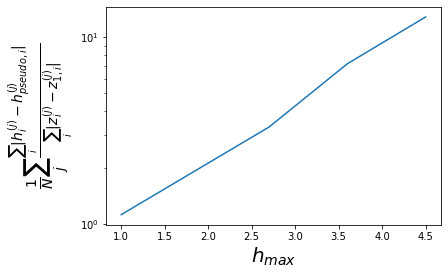

In [19]:
plt.plot(h_max,dds)
plt.xlabel(r'$h_{max}$',fontsize=20)
plt.ylabel(r'$\frac{1}{N}\sum_j \frac{\sum_i \left| h^{(j)}_i - h^{(j)}_{pseudo,i}\right|}{\sum_i \left| z^{(j)}_i - z^{(j)}_{1,i}\right|}$',fontsize=20)
plt.semilogy()
plt.show()